# Deep Convolutional GAN (DCGAN)

## Theory

In recent years, supervised learning with convolutional networks (CNNs) has seen huge adoption in computer vision applications. Comparatively, unsupervised learning with CNNs has received less attention.

We hope to help bridge the gap between the success of CNNs for supervised learning and unsupervised learning. We introduce a class of CNNs called deep convolutional generative adversarial networks (DCGANs), that have certain architectural constraints, and demonstrate that they are a strong candidate for unsupervised learning.

The deep convolutional generative adversarial network, or DCGAN for short, is an extension of the GAN architecture for using deep convolutional neural networks for both the generator and discriminator models and configurations for the models and training that result in the **stable** training of a generator model.

### Architecture guidelines for stable Deep Convolutional GANs:

+ Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
+ Use batchnorm in both the generator and the discriminator.
+ Remove fully connected hidden layers for deeper architectures.
+ Use ReLU activation in generator for all layers except for the output, which uses Tanh.
+ Use LeakyReLU activation in the discriminator for all layers.

## Advantages and Limitations

The DCGAN is important because it suggested the constraints on the model required to effectively develop high-quality generator models in practice. This architecture, in turn, provided the basis for the rapid development of a large number of GAN extensions and applications.

## References

Alec Radford et al., Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks, ICLR 2016.

In [1]:
import os
import time
import numpy as np

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True, source_url= 'http://yann.lecun.com/exdb/mnist/')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
mb_size = 128
X_dim = mnist.train.images.shape[1]
X_dim = int(np.sqrt(X_dim))
Z_dim = 100

epochs = 10
n_sample = 16

LeakyReLUs keep ReLU units from dying and are often used in GAN methods.

In [4]:
def leaky_relu(x, alpha=0.01):
    
    return tf.maximum(alpha * x, x)

+ Set placeholders of image input and noise vectors

In [5]:
X = tf.placeholder(tf.float32, shape=[None, X_dim, X_dim, 1]) #shape = [None,28,28,1]
Z = tf.placeholder(tf.float32, shape=[None, Z_dim]) #shape = [None, 100x1]

+ Latent/hidden variable $z$ can sample from any distributions, e.g., uniform distribution or normal distribution.

In [6]:
def sample_Z(m, n):
    
    return np.random.uniform(-1., 1., size=[m, n])

+ Generator $G$ and Discriminator $D$ are two networks, e.g., ConvNets or Multi-Layer Perceptrons (MLP). Here, ConvNets.

In [7]:
def generator(z, is_train=True):
    with tf.variable_scope("G", reuse=tf.AUTO_REUSE):
        #100x1 to 4x4x512
        layer1 = tf.layers.dense(z, 4*4*512)
        layer1 = tf.reshape(layer1, [-1, 4, 4, 512])
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = leaky_relu(layer1)
        layer1 = tf.nn.dropout(layer1, keep_prob=0.8)
        
        #4x4x512 to 7x7x256
        layer2 = tf.layers.conv2d_transpose(layer1, 256, 4, strides=1, padding='valid')
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = leaky_relu(layer2)
        layer2 = tf.nn.dropout(layer2, keep_prob=0.8)
        
        #7x7x256 to 14x14x128
        layer3 = tf.layers.conv2d_transpose(layer2, 128, 3, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = leaky_relu(layer3)
        layer3 = tf.nn.dropout(layer3, keep_prob=0.8)
        
        #14x14x128 to 28x28x1
        G_log_prob = tf.layers.conv2d_transpose(layer3, 1, 3, strides=2, padding='same')
        G_prob = tf.tanh(G_log_prob)
        
        return G_prob
        
def discriminator(x):
    with tf.variable_scope("D", reuse=tf.AUTO_REUSE):
        #28x28x1 to 14x14x128
        layer1 = tf.layers.conv2d(x, 128, 3, strides=2, padding='same')
        layer1 = leaky_relu(layer1)
        layer1 = tf.nn.dropout(layer1, keep_prob=0.8)
        
        #14x14x128 to 7x7x256
        layer2 = tf.layers.conv2d(layer1, 256, 3, strides=2, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = leaky_relu(layer2)
        layer2 = tf.nn.dropout(layer2, keep_prob=0.8)
        
        #7x7x256 to 4x4x512
        layer3 = tf.layers.conv2d(layer2, 512, 3, strides=2, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = leaky_relu(layer3)
        layer3 = tf.nn.dropout(layer3, keep_prob=0.8)
        
        #4x4x512 to 4*4*512x1
        flatten = tf.reshape(layer3, (-1, 4*4*512))
        D_logit = tf.layers.dense(flatten, 1)
        D_prob = tf.sigmoid(D_logit)
        
        return D_prob, D_logit

In [8]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [9]:
G_sample = generator(Z)

D_real, D_logit_real = discriminator(X)
D_fake, D_logit_fake = discriminator(G_sample)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.


+ Loss functions

In [10]:
# D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
# G_loss = -tf.reduce_mean(tf.log(D_fake))

# Alternative losses:
# -------------------
smooth = 0.1
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)*(1-smooth)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)*(1-smooth)))

train_vars = tf.trainable_variables()
theta_D = [var for var in train_vars if var.name.startswith("D")]
theta_G = [var for var in train_vars if var.name.startswith("G")]

with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
    G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


+ In the DCGAN, the generator and the discriminator model must be updated in equal amounts. Specifically, the discriminator is updated with a half batch of real and a half batch of fake samples each iteration, whereas the generator is updated with a single batch of generated samples.

In [11]:
if not os.path.exists('GAN-DCGAN/'):
    os.makedirs('GAN-DCGAN/')

losses = {'discriminator': [], 'generator': []}    

i = 0

start = time.time()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        for mb_i in range(mnist.train.num_examples//mb_size):
            batch = mnist.train.next_batch(mb_size)
            X_mb = batch[0].reshape((mb_size, X_dim, X_dim, 1))
            # scale to [-1,1]
            #X_mb = X_mb*2 - 1
            Z_noise = sample_Z(mb_size, Z_dim)
            
            _ = sess.run(D_solver, feed_dict={X: X_mb, Z: Z_noise})
            _ = sess.run(G_solver, feed_dict={X: X_mb, Z: Z_noise})
            
            if mb_i % 50 == 0:
                D_loss_curr = D_loss.eval({X: X_mb, Z: Z_noise})
                G_loss_curr = G_loss.eval({Z: Z_noise})
                
                print('Epoch {}/{}, batch {}'.format(epoch+1, epochs, mb_i))
                print('D_loss: {:.4}'. format(D_loss_curr))
                print('G_loss: {:.4}'.format(G_loss_curr))
                print('\n')
                
                losses['discriminator'].append(D_loss_curr)
                losses['generator'].append(G_loss_curr)
                
                samples = sess.run(generator(Z, False), feed_dict={Z: sample_Z(n_sample, Z_dim)})
                samples = np.squeeze(samples, -1)
                
                fig = plot(samples)
                plt.savefig('GAN-DCGAN/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
                plt.close(fig)
                
                i += 1
                
elapsed = time.time() - start

Epoch 1/10, batch 0
D_loss: 1.595
G_loss: 1.277


Epoch 1/10, batch 50
D_loss: 0.3649
G_loss: 5.576


Epoch 1/10, batch 100
D_loss: 0.3554
G_loss: 6.266


Epoch 1/10, batch 150
D_loss: 0.3978
G_loss: 5.11


Epoch 1/10, batch 200
D_loss: 0.3688
G_loss: 5.654


Epoch 1/10, batch 250
D_loss: 0.3839
G_loss: 3.586


Epoch 1/10, batch 300
D_loss: 0.3569
G_loss: 4.626


Epoch 1/10, batch 350
D_loss: 0.3679
G_loss: 4.498


Epoch 1/10, batch 400
D_loss: 0.3786
G_loss: 4.023


Epoch 2/10, batch 0
D_loss: 0.3661
G_loss: 4.364


Epoch 2/10, batch 50
D_loss: 0.3661
G_loss: 4.876


Epoch 2/10, batch 100
D_loss: 0.4052
G_loss: 3.69


Epoch 2/10, batch 150
D_loss: 0.3649
G_loss: 5.68


Epoch 2/10, batch 200
D_loss: 0.3585
G_loss: 4.862


Epoch 2/10, batch 250
D_loss: 0.3821
G_loss: 4.483


Epoch 2/10, batch 300
D_loss: 0.37
G_loss: 4.113


Epoch 2/10, batch 350
D_loss: 0.4481
G_loss: 5.697


Epoch 2/10, batch 400
D_loss: 0.5025
G_loss: 7.085


Epoch 3/10, batch 0
D_loss: 0.3689
G_loss: 4.669


Epoch 3

In [14]:
print('The elapsed time after training the network is %.1fh'%(elapsed/3600))

The elapsed time after training the network is 5.2h


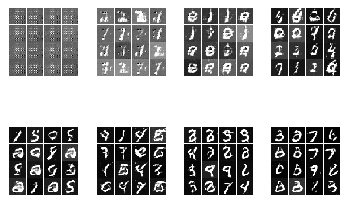

In [15]:
plt.figure()

ax = plt.subplot(241)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan1 = plt.imread('GAN-DCGAN/000.png')
plt.imshow(gan1, cmap='Greys_r')

ax = plt.subplot(242)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan2 = plt.imread('GAN-DCGAN/015.png')
plt.imshow(gan2, cmap='Greys_r')

ax = plt.subplot(243)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan3 = plt.imread('GAN-DCGAN/030.png')
plt.imshow(gan3, cmap='Greys_r')

ax = plt.subplot(244)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan4 = plt.imread('GAN-DCGAN/040.png')
plt.imshow(gan4, cmap='Greys_r')

ax = plt.subplot(245)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan5 = plt.imread('GAN-DCGAN/045.png')
plt.imshow(gan5, cmap='Greys_r')

ax = plt.subplot(246)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan6 = plt.imread('GAN-DCGAN/060.png')
plt.imshow(gan6, cmap='Greys_r')

ax = plt.subplot(247)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan7 = plt.imread('GAN-DCGAN/075.png')
plt.imshow(gan7, cmap='Greys_r')

ax = plt.subplot(248)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan8 = plt.imread('GAN-DCGAN/085.png')
plt.imshow(gan8, cmap='Greys_r')

plt.show()

+ Performance estimation

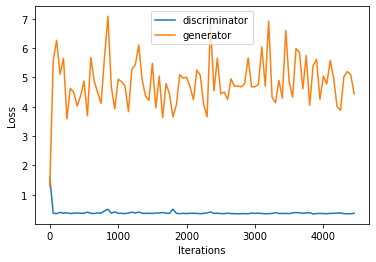

In [17]:
# plotting the learning curves
plt.figure()
plt.plot(np.arange(len(losses['discriminator']))*50, losses['discriminator'], label='discriminator')
plt.plot(np.arange(len(losses['generator']))*50, losses['generator'], label='generator')
plt.xlabel(r'Iterations')
plt.ylabel(r'Loss')
plt.legend()
plt.show()